In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Modell:
$sin(x)=y$

$x$ wird gesucht.

In [3]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [4]:
def model_func(x):
    return np.sin(x)

In [5]:
y = model_func(x)

Verlustfunktion: quadratischer Fehler $\frac{1}{n}\Vert y - \hat{y}\Vert^2$

In [6]:
from sklearn.metrics import mean_squared_error

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-\frac{2}{n}(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))

0.46930182961014055

## EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 100
particles = 100
randomization = False

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = model_func(param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, model_func(param_mean)))

In [15]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, model_func(param_dict["particle_{}".format(i+1)]))]

### EnKF

In [16]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = model_func(param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
    d = np.transpose(d)
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(mean_squared_error(y, model_func(param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, model_func(param_dict["particle_{}".format(i+1)])))

In [17]:
loss_evolution[-10:]

[0.0008632927500827773,
 0.0008540716736793038,
 0.0008451769546175918,
 0.0008365922016690619,
 0.0008283020558234469,
 0.0008202921135535456,
 0.0008125488565639039,
 0.000805059587423667,
 0.0007978123705276077,
 0.0007907959779037785]

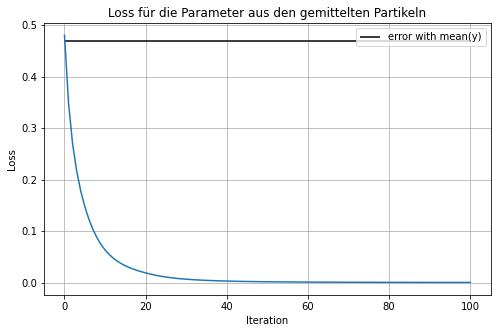

In [18]:
plt.figure(figsize = (8,5))
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 0, xmax = len(loss_evolution) - 1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution)), loss_evolution)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

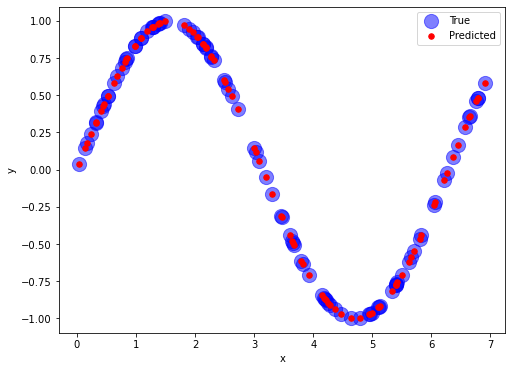

In [19]:
plt.figure(figsize = (8,6))
plt.scatter(x, y, color = "blue", s = 200, alpha = 0.5, label = "True")
plt.scatter(x, model_func(x), color = "red", s = 30, label = "Predicted")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Jetzt das gleiche mit Noise auf $y$

In [20]:
np.random.seed(42)

## Modell:
$\sin(x)=y + \eta$ mit $\eta\sim\mathscr{N}(0,\Gamma)$

$x$ wird gesucht.

In [21]:
x = np.random.uniform(low = 0,
                      high = 7,
                      size = (100, ))

In [22]:
def model_func(x):
    return np.sin(x)

In [23]:
stddev = np.absolute(np.random.normal(loc = 0,
                                      scale = 0.5,
                                      size = (x.shape[0], )))

In [24]:
y = model_func(x) + np.random.normal(loc = 0,
                                     scale = stddev,
                                     size = (x.shape[0], ))

Verlustfunktion: mittlerer quadratischer Fehler $\frac{1}{n}\Vert y - \hat{y}\Vert^2_{\Gamma}$

In [25]:
def mse_gamma(y_true, y_pred):
    new_diffs = np.dot(np.sqrt(np.linalg.inv(np.diag(stddev))), y_true - y_pred)
    return np.mean(new_diffs**2)

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 
    
$-\frac{2}{n}\Gamma_{ii}(y_i-\hat{y}_i)$

In [26]:
def grad_loss_gamma(y_true, y_pred):
    return (-2) / y_true.shape[0] * np.diag(np.sqrt(np.linalg.inv(np.diag(stddev)))) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [27]:
mean_squared_error(y, np.ones(y.shape[0])*np.mean(y))

0.862836731376971

## EnKF

In [28]:
iterations = 100
particles = 100
randomization = False

In [29]:
h_0 = 2
epsilon = 0.5

In [30]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [31]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = model_func(param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [32]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [33]:
loss_evolution = []
loss_evolution.append(mean_squared_error(y, model_func(param_mean)))

In [34]:
# zum Testen der einzelnen Partikel
loss_evolution_single_dict = {}
for i in range(particles):
    loss_evolution_single_dict["particle_{}".format(i+1)] = [mean_squared_error(y, model_func(param_dict["particle_{}".format(i+1)]))]

### EnKF

In [35]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = model_func(param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = mean_squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
    d = np.transpose(d)
           
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
        if randomization:
            # add randomization/ noise to each particle
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_param = param_dict["particle_{}".format(str(i+1))] + noise
            param_dict["particle_{}".format(str(i+1))] = new_param
    if randomization:
        # randomize particles around their mean
        param_dict_mean = list(np.mean(list(param_dict.values()), axis = 0))
        for i in range(particles):
            stddev = 0.1
            noise = np.random.normal(loc = 0.0,
                                     scale = stddev,
                                     size = param_dict["particle_{}".format(str(i+1))].shape)
            new_params = param_dict_mean + noise
            param_dict["particle_{}".format(str(i+1))] = new_params
    
    # compute loss for the parameter means
    param_mean = np.mean(params_all_ptcls, axis = 0)
    loss_evolution.append(mean_squared_error(y, model_func(param_mean)))
    
    # zum Testen der einzelnen Partikel
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)].append(mean_squared_error(y, model_func(param_dict["particle_{}".format(i+1)])))

In [36]:
loss_evolution[-10:]

[0.13444755824774815,
 0.13444194759476563,
 0.1345531116003335,
 0.13454308414391408,
 0.13464034287764143,
 0.13462505112885498,
 0.13470560748461533,
 0.13468481284603745,
 0.1347468287620249,
 0.13472092491800836]

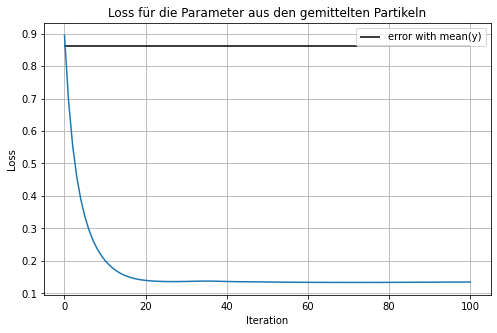

In [37]:
plt.figure(figsize = (8,5))
plt.hlines(y = mean_squared_error(y, np.ones(y.shape[0])*np.mean(y)), xmin = 0, xmax = len(loss_evolution) - 1, color = "black", label = "error with mean(y)")
plt.plot(np.arange(len(loss_evolution)), loss_evolution)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss für die Parameter aus den gemittelten Partikeln")
plt.show()

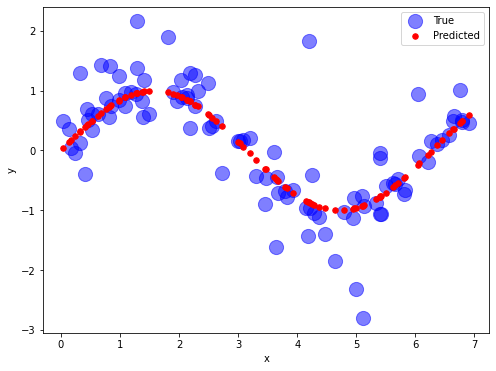

In [38]:
plt.figure(figsize = (8,6))
plt.scatter(x, y, color = "blue", s = 200, alpha = 0.5, label = "True")
plt.scatter(x, model_func(x), color = "red", s = 30, label = "Predicted")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()